In [1]:
import utils
import r_pca

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

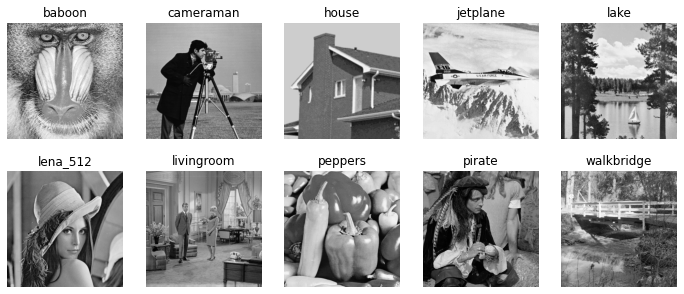

In [3]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [4]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])

In [5]:
dataset.shape

(10, 512, 512)

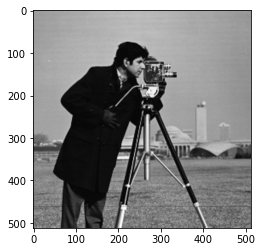

In [6]:
plt.imshow(dataset[1], cmap='gray')

In [7]:
d = 9
matrix_modes = [2] * d
original = dataset[1] / 255.

vector, vector_modes = utils.matrix_to_vector(original, d, matrix_modes)

In [ ]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    vector,
    d,
    vector_modes
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4
